In [227]:
import networkx as nx
import powerlaw as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter 
from networkx.algorithms.community.quality import modularity
import EoN
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [228]:
G = nx.read_edgelist('LFM1.csv', delimiter=',')

In [237]:
print(G)
G.degree['3942']

Graph with 7624 nodes and 27806 edges


10

In [224]:
# Parameters
beta = 0.3 # transmission rate
gamma = 0.1  # recovery rate
initial_infected = [5851]  # starting point
G = nx.convert_node_labels_to_integers(G, first_label=0)
 
# Run the SIR model on the network
sim = EoN.fast_SIR(G, beta, gamma, initial_infecteds=initial_infected, return_full_data=True)
 
# Access the data from the Simulation_Investigation object
t, S, I, R, full_data = sim.t(), sim.S(), sim.I(), sim.R(), sim.get_statuses(nodelist=list(G.nodes()), time=150)
 
# Plot the results
# plt.plot(t, S, label='Susceptible')
# plt.plot(t, I, label='Infected')
# plt.plot(t, R, label='Recovered')
# plt.xlabel('Time')
# plt.ylabel('Number of nodes')
# plt.title('SIR Model')
# plt.legend()
# plt.show()
recovered = 0
for i in range(len(list(G.nodes()))):
    if full_data[i] == 'R':
        recovered +=1
print(np.round(recovered/(len(list(G.nodes()))), 5))
np.round(max(t))

0.90779


80.0

In [225]:

print("Max Infected at a given time: ", max(I), np.round(t[I[(max(I))]]))

Max Infected at a given time:  4604 4.0


Now we are going to do community discovery. We are going to use networkx module **community**.

In [53]:
# Run Label Propagation algorithm
# import community
communities_lp = nx.algorithms.community.label_propagation.label_propagation_communities(G)
communities_louvain = nx.algorithms.community.louvain_communities(G)
communities_greedy_mod = nx.algorithms.community.greedy_modularity_communities(G)

# Convert communities to a list for better visualization
communities_list_lp = [list(community) for community in communities_lp]
communities_list_louvain = [list(community) for community in communities_louvain]
communities_list_gm = [list(community) for community in communities_greedy_mod]

# Print the detected communities
# print("Detected Communities:")
# for i, community in enumerate(communities_list):
#     print(f"Community {i + 1}: {community}")


In [54]:
print(len(communities_list_lp))
print(len(communities_list_louvain))
print(len(communities_list_gm))

modularity_lp = modularity(G, communities_list_lp)
modularity_louvain = modularity(G, communities_list_louvain) #the chosen one
modularity_gm = modularity(G, communities_list_gm)
print(modularity_lp)
print(modularity_louvain)
print(modularity_gm)
#print modularity

650
28
44
0.7522556757225006
0.8157813971297904
0.7955830887901616


In [87]:
# lengths_com = [(len(c)/7624)*100 for c in communities_list_louvain]
lengths_com = [len(c) for c in communities_list_louvain]
print(sorted(lengths_com, reverse=True))

[1122, 1016, 929, 861, 666, 663, 500, 466, 271, 240, 197, 155, 126, 97, 70, 64, 60, 42, 13, 12, 11, 11, 7, 7, 5, 5, 4, 4]


In [92]:
min([len(c) for c in communities_list_louvain])

4

We chose louvain communities algorithm, because it gives highest modularity and a stable number of communities (read more about it). 

We saw there are some communities on the bottom that only contain 5-4 nodes, so we will ignore them (why? - think of good reason). 

So we take the top 16 communities, each containing more than 1% of the nodes in the network.

From those we choose the biggest, smallest and middle one and see how the contagion spreads when we infect the nodes in them with highes degree/betweenness centrality. That should give us 3 different models. For each of them we will try several combinations of infection and recovery rate.

We want to also see a random case in which we randomly choose a node/3 nodes from the network, regardless of community.

OUR RESEARCH QUESTION: **Is the speed of the spread influenced by the size of the community associated with the initial node?**

In [93]:
#limitation: not 100% likely that people will be in a single disjoint community; in future we are going to extend this to overlapping communities.

In [107]:
sorted_communities = sorted(communities_list_louvain, key = len, reverse = True)
result_dict = {i: sorted_communities[i] for i in range(1,len(sorted_communities))}
merged_list = [item for sublist in sorted_communities[14:] for item in sublist]

# Remove the first 16 key-value pairs
for i in range(14,len(sorted_communities)):
    result_dict.pop(i, None)

# Add the merged list as the 17th key-value pair
result_dict[14] = merged_list

# Print the resulting dictionary
print(len(result_dict[13]))

97


In [166]:
A = result_dict[1]
B = result_dict[13]
C = result_dict[14]

In [159]:
# the largest community
A_node_degree = {}
for node in A:
    A_node_degree[node] = G.degree(node)


found_key_A = next((key for key, value in A_node_degree.items() if value == max(A_node_degree.values())), None)
found_key_A

'7237'

In [165]:
# the smalest community
B_node_degree = {}
for node in B:
    B_node_degree[node] = G.degree(node)


found_key_B = next((key for key, value in B_node_degree.items() if value == max(B_node_degree.values())), None)
found_key_B


'3571'

In [164]:
# without community
C_node_degree = {}
for node in C:
    C_node_degree[node] = G.degree(node)


found_key_C = next((key for key, value in C_node_degree.items() if value == max(C_node_degree.values())), None)
found_key_C


'5851'

In [235]:
community_graph = G.subgraph(C)

# Calculate betweenness centrality for each node in the community
betweenness_centrality = nx.betweenness_centrality(community_graph)

# Find the node with the highest betweenness centrality
node_highest_betweenness = max(betweenness_centrality, key=betweenness_centrality.get)

In [236]:
node_highest_betweenness

'3942'

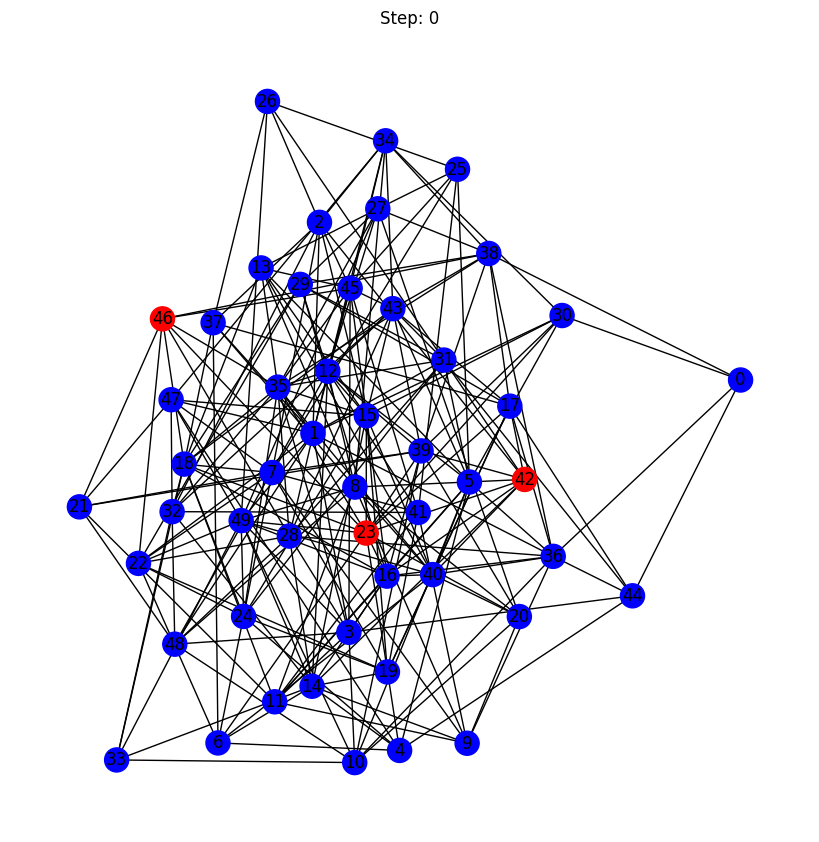

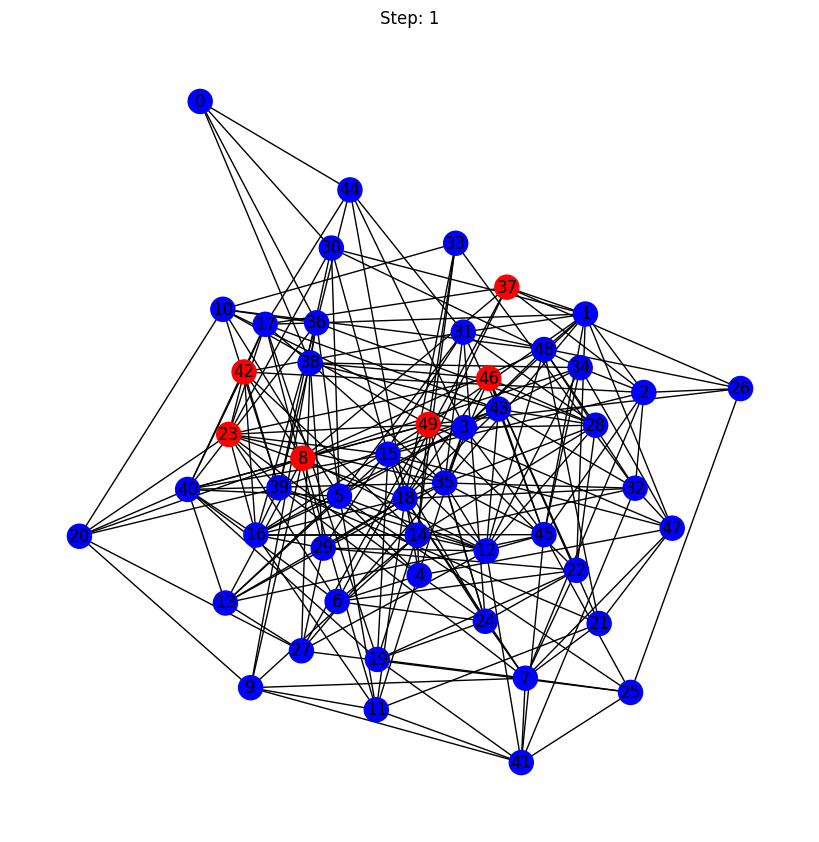

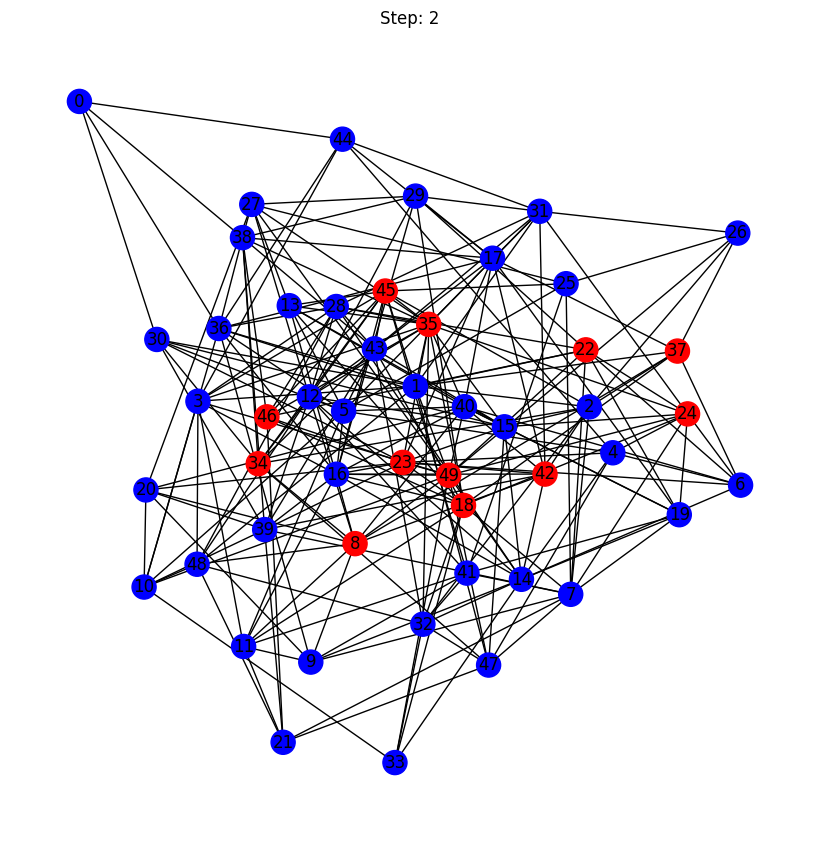

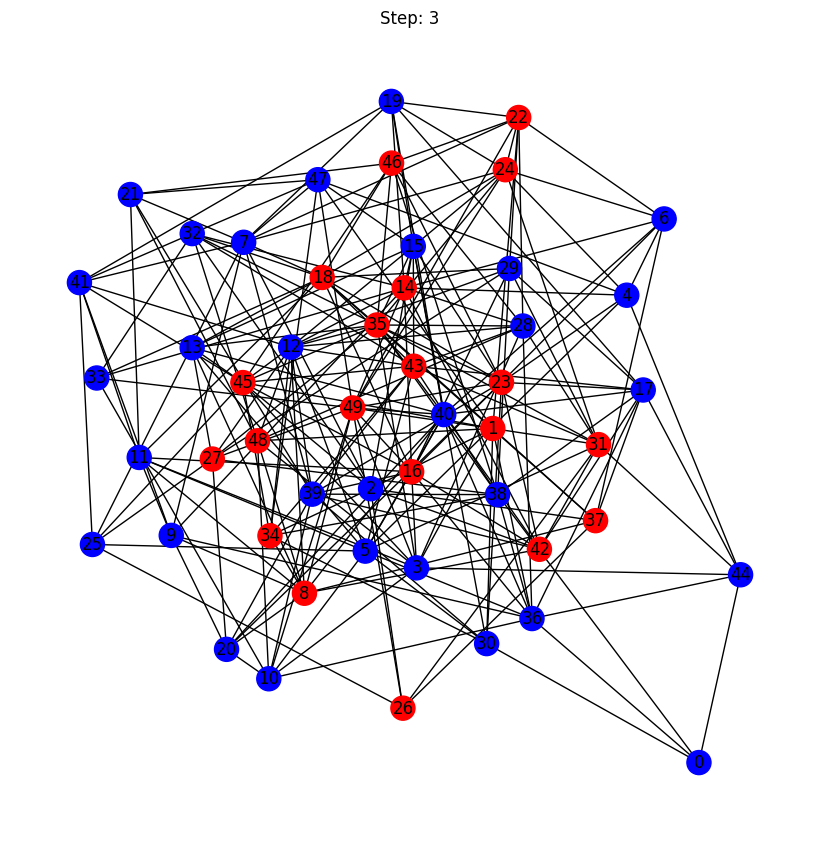

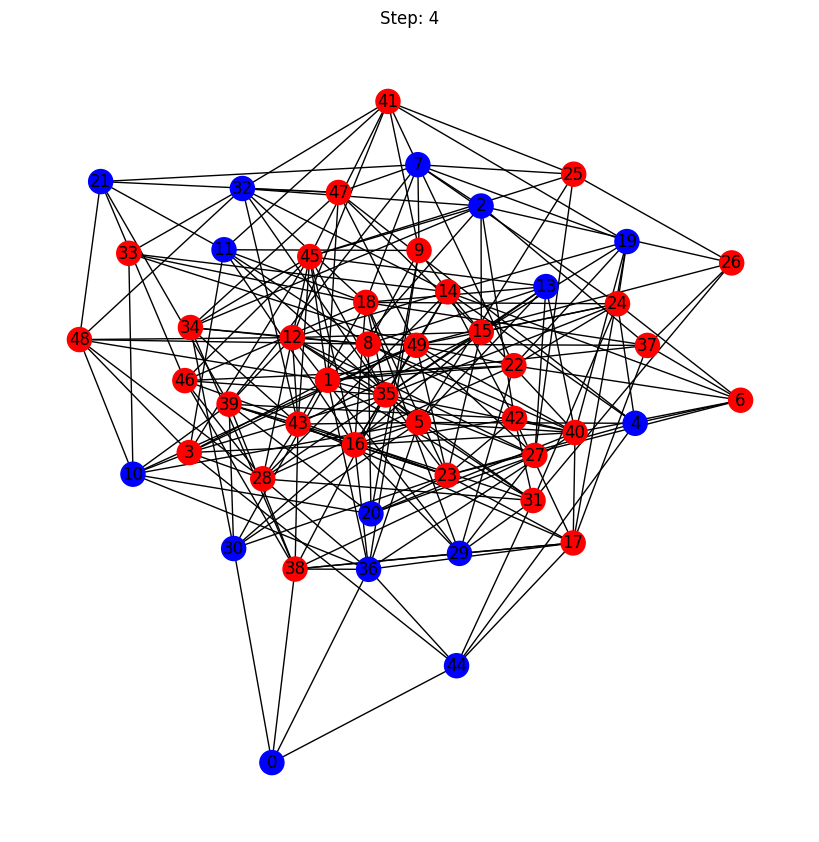

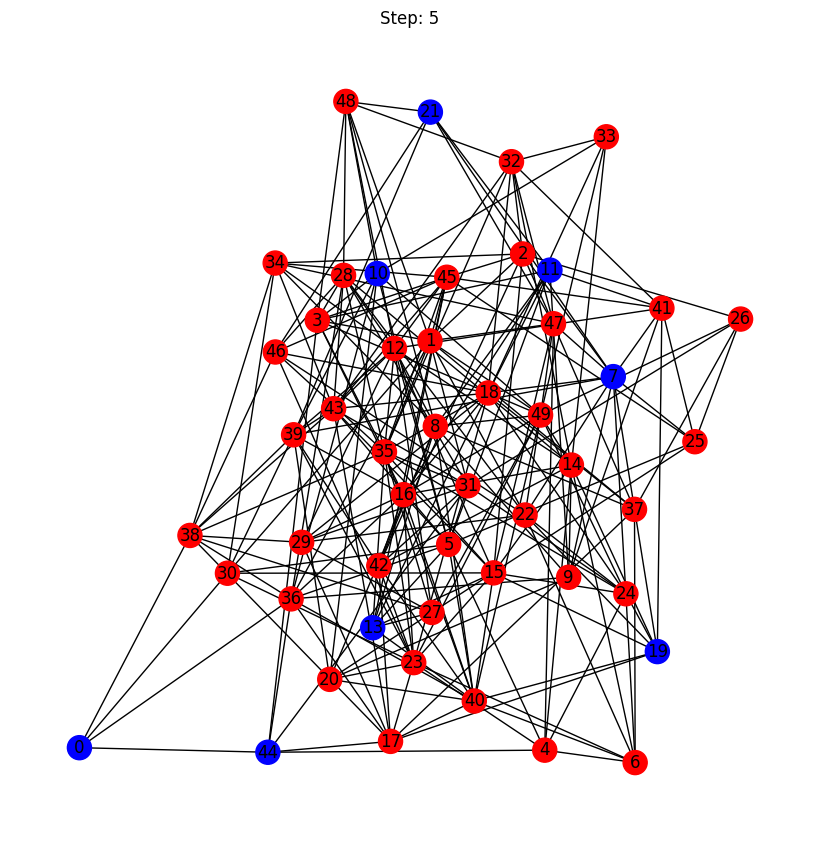

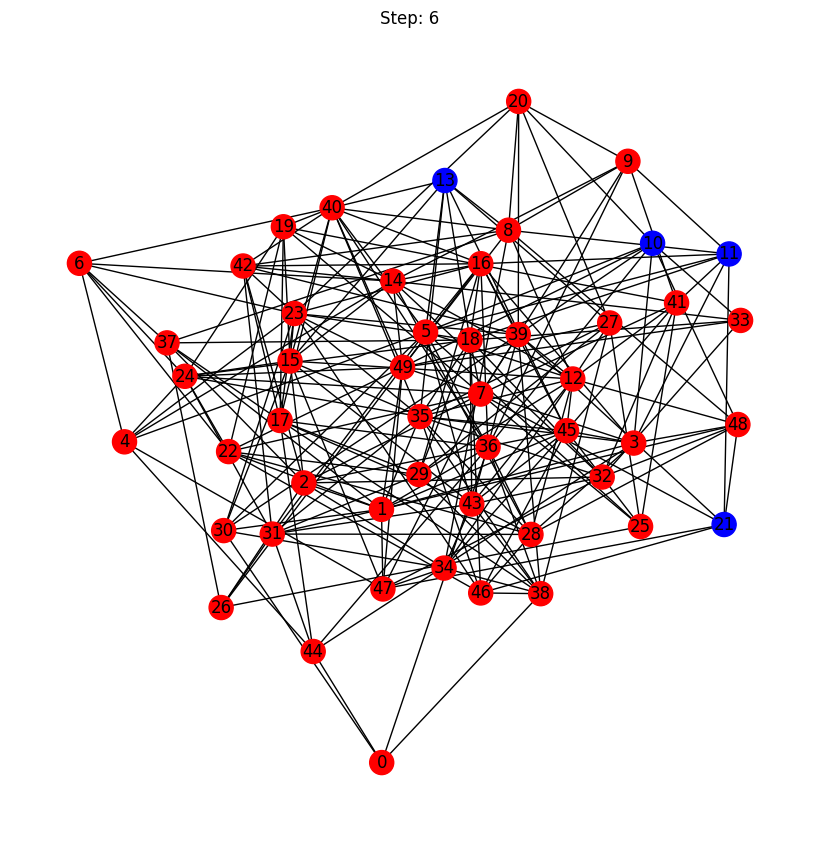

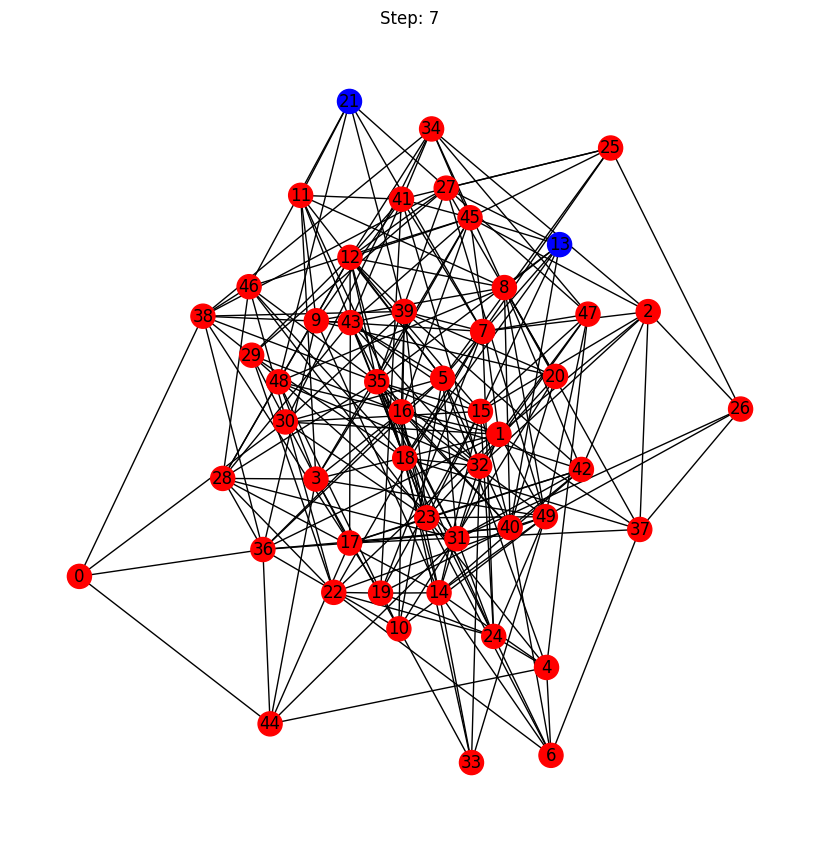

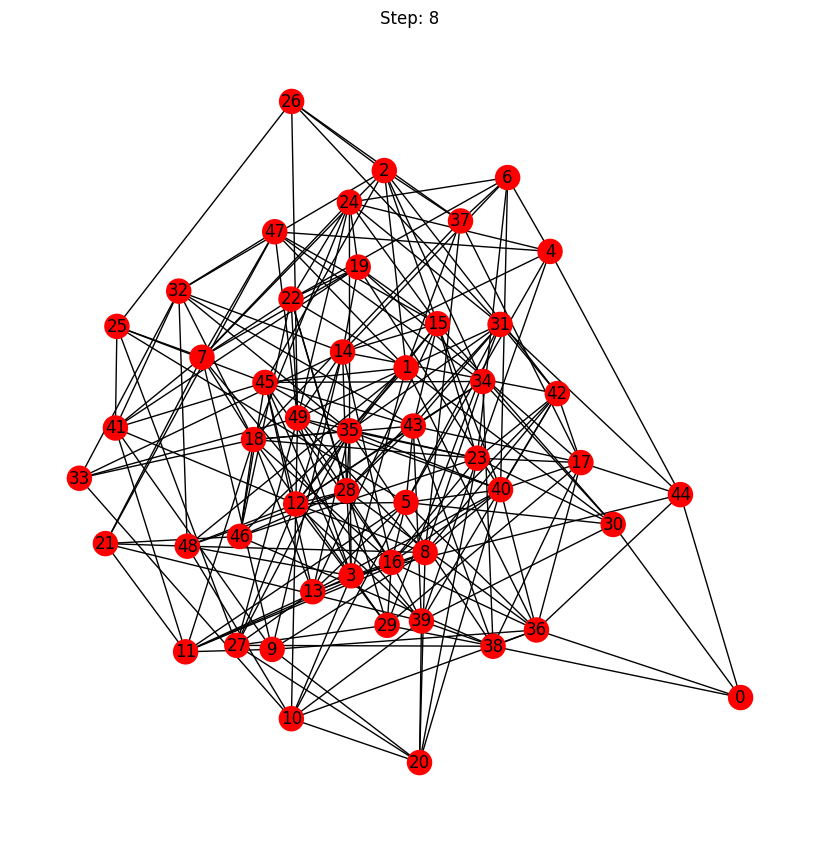

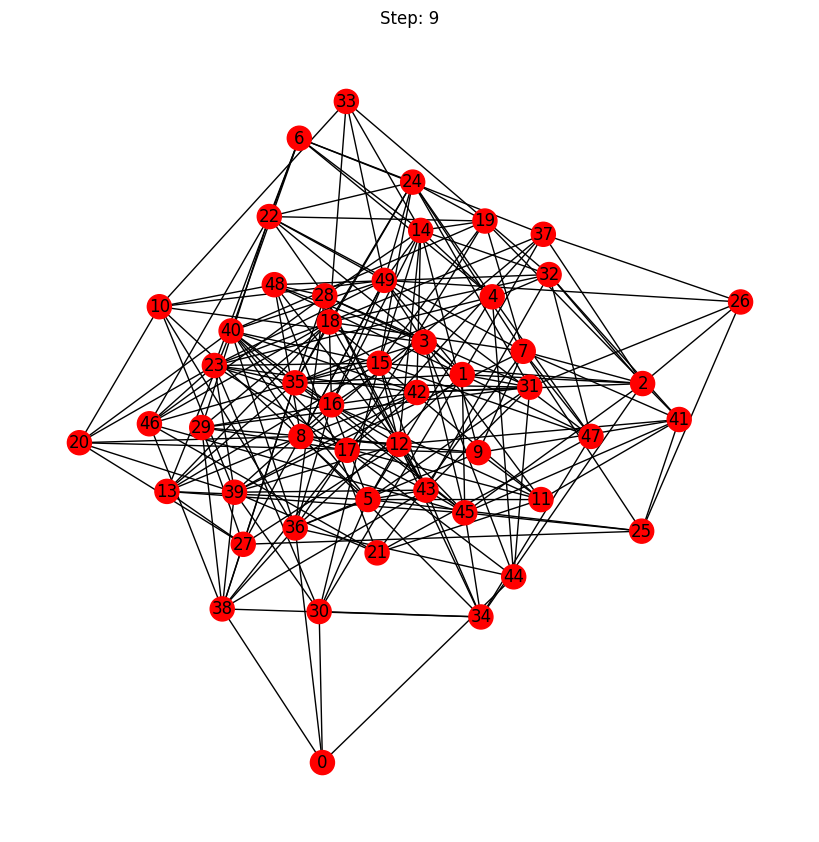

In [248]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def initialize_network_status(G):
    # Initialize nodes with 'susceptible' status
    node_status = {node: 'susceptible' for node in G.nodes()}
    nx.set_node_attributes(G, node_status, 'status')

    # Infect a random node to start the spread
    initial_infected_node = random.choice(list(G.nodes()))
    G.nodes[initial_infected_node]['status'] = 'infected'

def spread_disease(G, infection_prob):
    for node in G.nodes():
        if G.nodes[node]['status'] == 'susceptible':
            neighbors = list(G.neighbors(node))
            infected_neighbors = [n for n in neighbors if G.nodes[n]['status'] == 'infected']
            for infected_neighbor in infected_neighbors:
                if random.random() < infection_prob:
                    G.nodes[node]['status'] = 'infected'

def plot_network_status(G, step):
    pos = nx.spring_layout(G)
    colors = {'susceptible': 'blue', 'infected': 'red'}
    node_colors = [colors[G.nodes[node]['status']] for node in G.nodes()]
    
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors)
    plt.title(f'Step: {step}')
    plt.show()

def simulate_si_model_on_existing_network(G, infection_prob, num_steps):
    initialize_network_status(G)

    for step in range(num_steps):
        spread_disease(G, infection_prob)
        plot_network_status(G, step)

if __name__ == "__main__":
    # Assume you already have a graph G
    G = nx.erdos_renyi_graph(50, 0.2)

    infection_prob = 0.1
    num_steps = 10

    simulate_si_model_on_existing_network(G, infection_prob, num_steps)


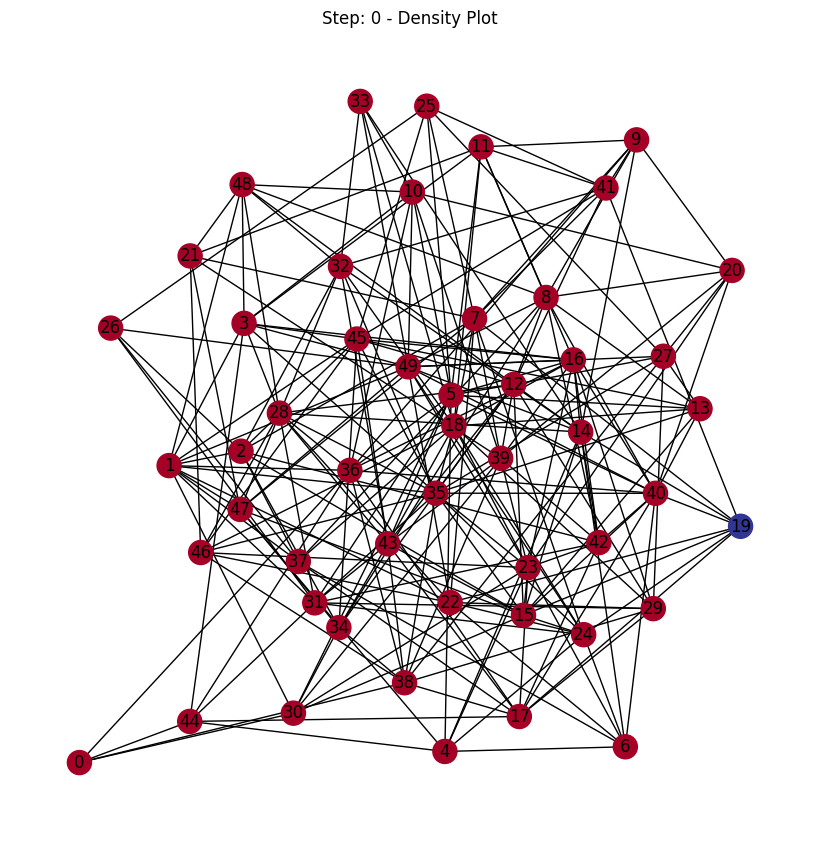

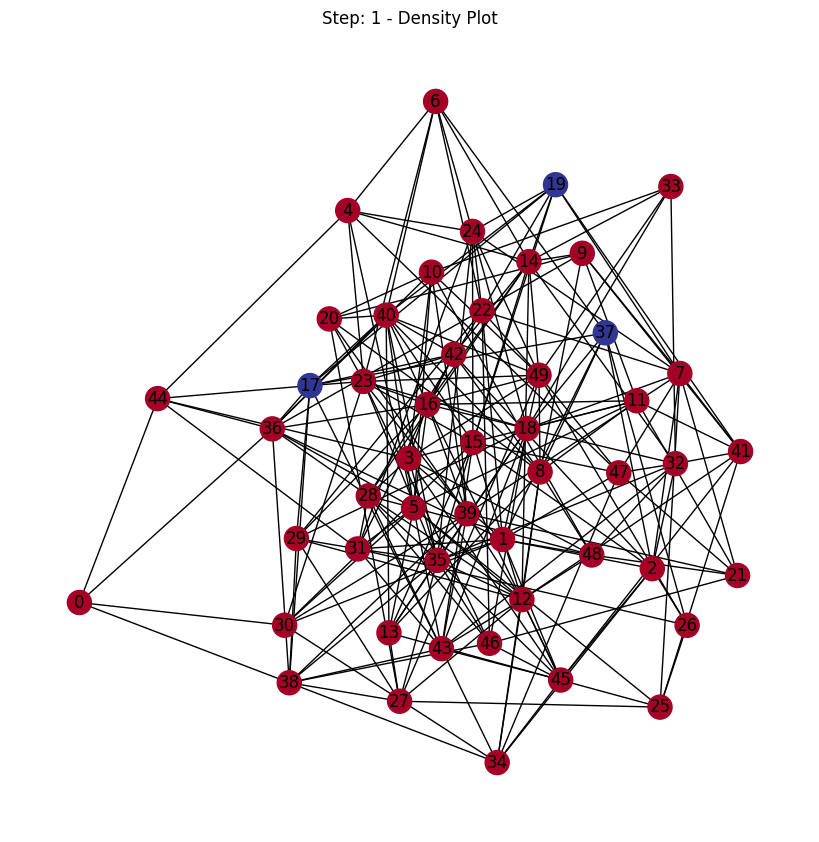

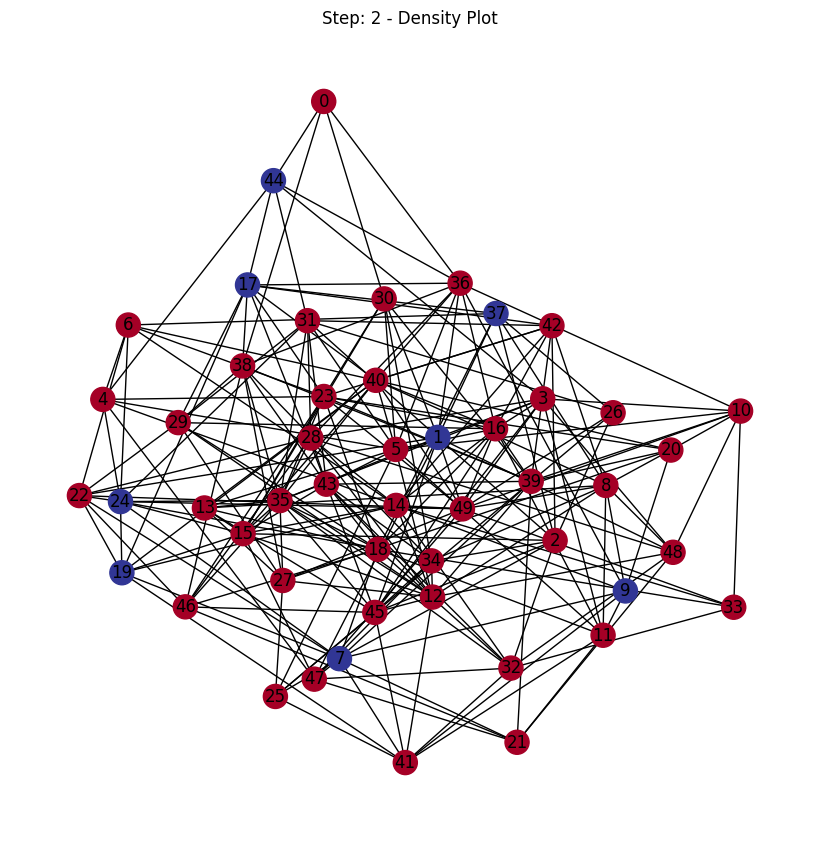

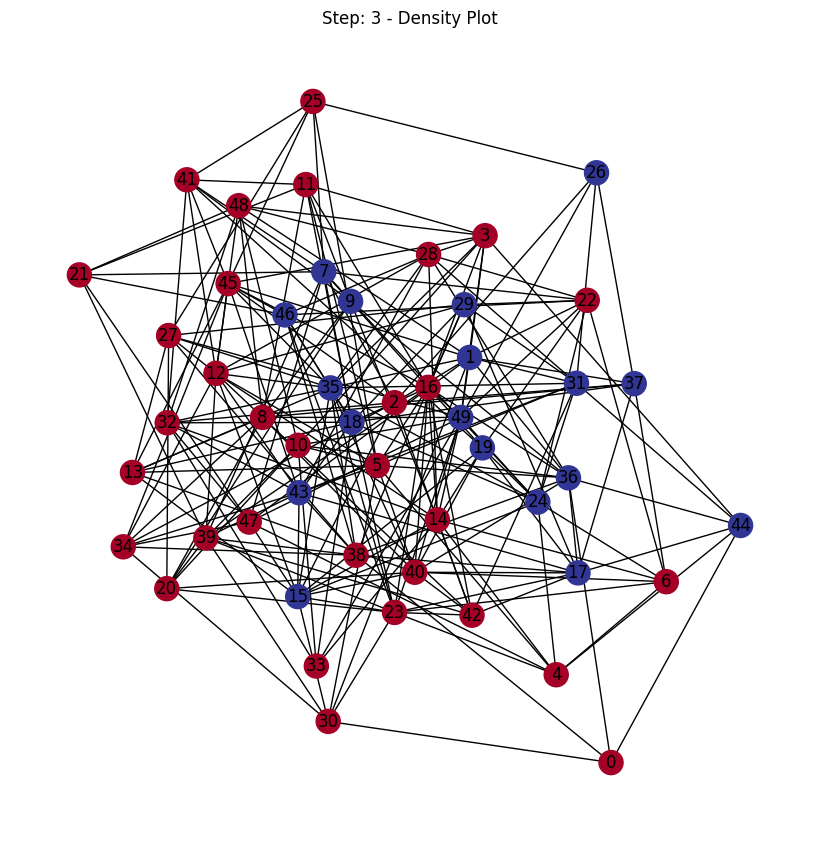

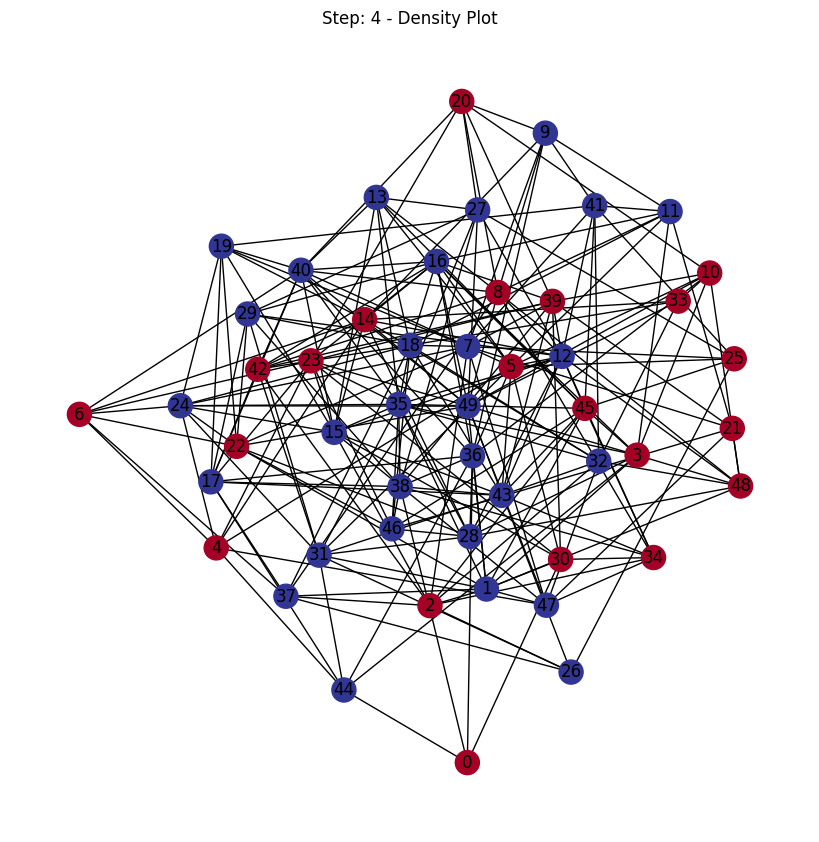

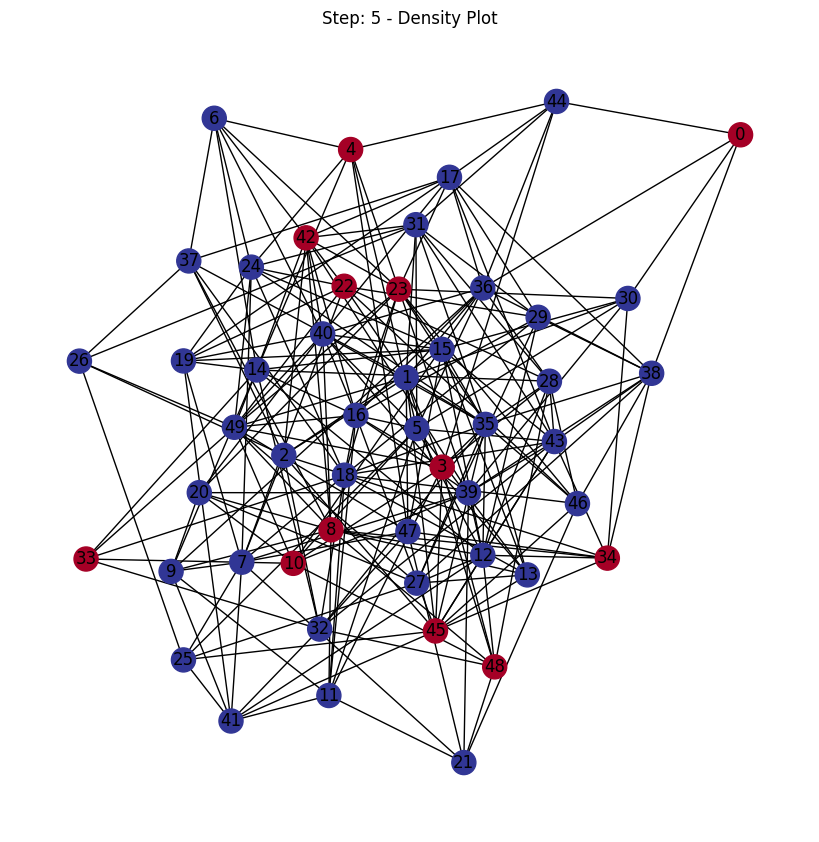

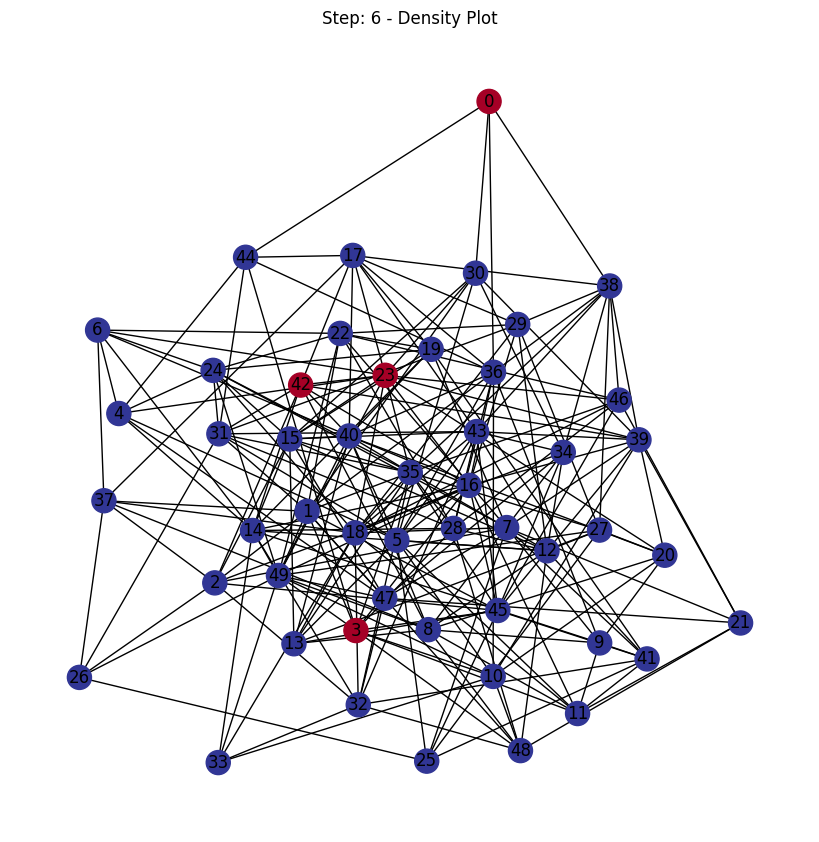

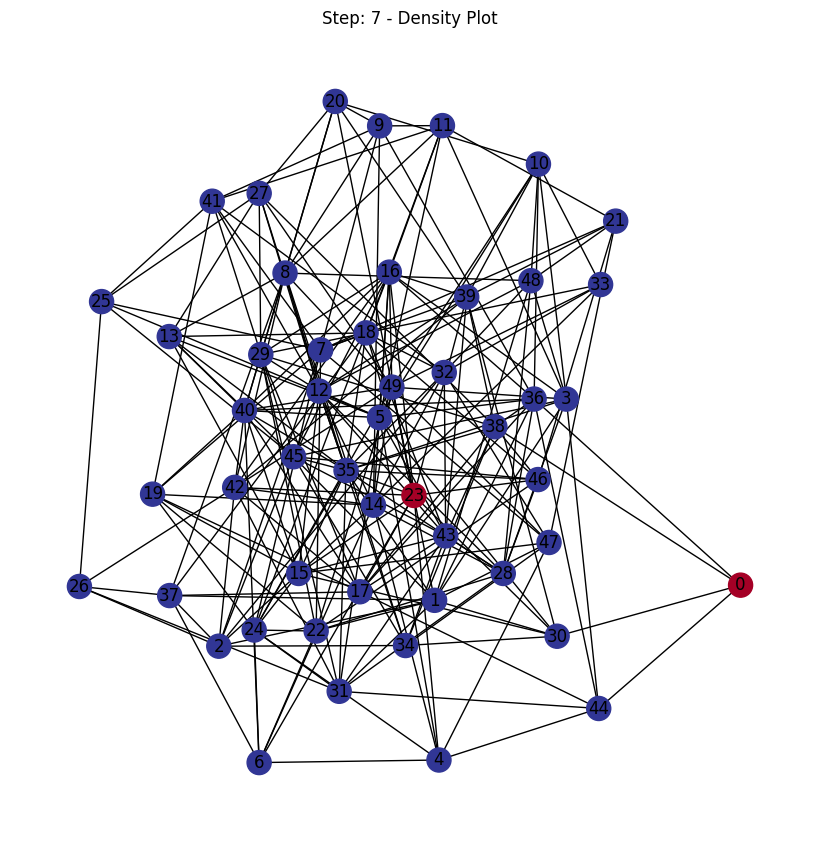

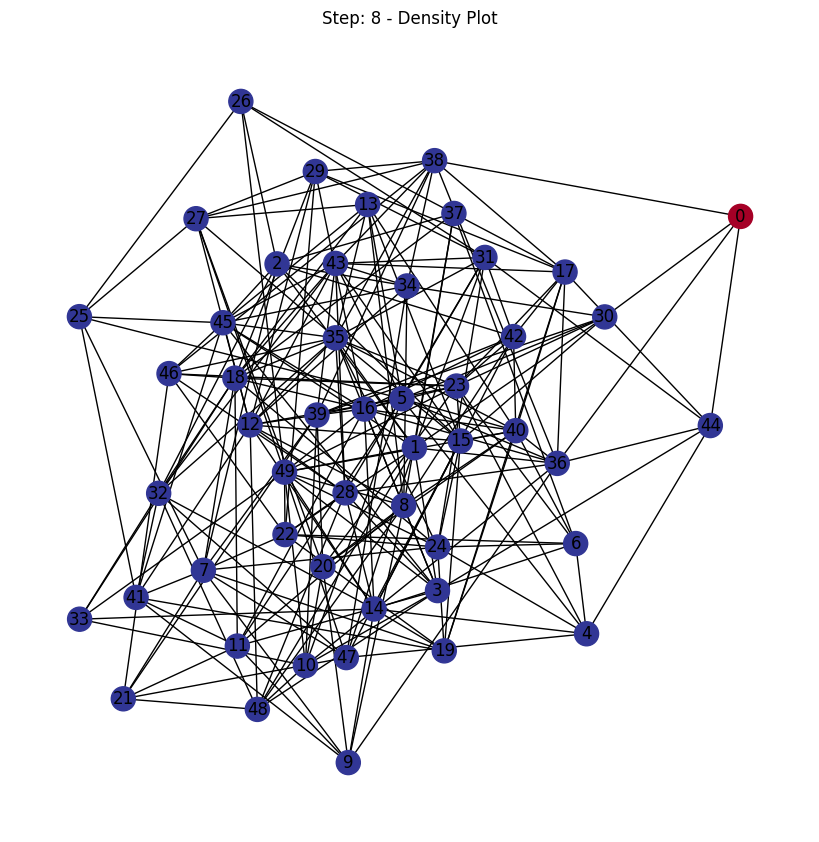

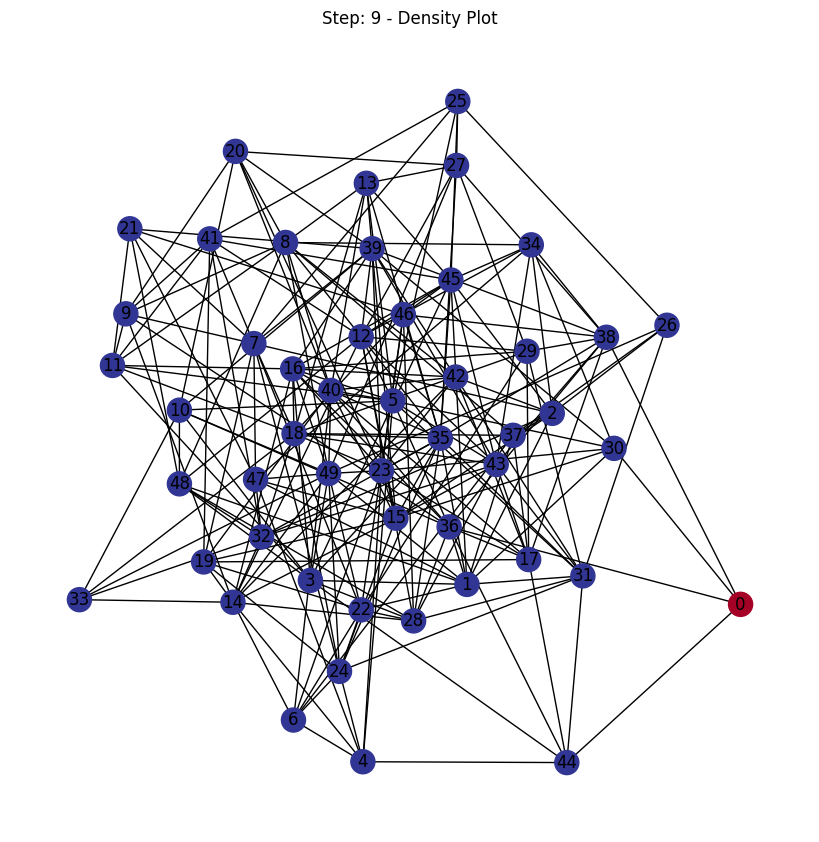

In [249]:
import numpy as np

def plot_density(G, step):
    node_positions = nx.spring_layout(G)
    statuses = nx.get_node_attributes(G, 'status')
    colors = {'susceptible': 0, 'infected': 1}

    node_colors = np.array([colors[statuses[node]] for node in G.nodes()])
    cmap = plt.cm.RdYlBu  # You can choose a different colormap

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos=node_positions, node_color=node_colors, cmap=cmap, with_labels=True)
    plt.title(f'Step: {step} - Density Plot')
    plt.show()

def simulate_si_model_on_existing_network(G, infection_prob, num_steps):
    initialize_network_status(G)

    for step in range(num_steps):
        spread_disease(G, infection_prob)
        plot_density(G, step)



infection_prob = 0.1
num_steps = 10

simulate_si_model_on_existing_network(G, infection_prob, num_steps)
